In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.markers as mmark
from matplotlib.ticker import PercentFormatter

from latex_figure import LatexFigure

sys.path.append("/home/bf16951/QMD")
import qmla

In [2]:
SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 11

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fon

font = {'family' : 'serif',
        'weight' : 'normal',
}

plt.rc('font', **font)

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})



In [6]:
# Use a QMLA instance to get some useful objects

results_time = 'Aug_29/18_30'

results_folder = os.path.abspath("/home/bf16951/QMD/Launch/Results/")
results_dir = os.path.join(
    results_folder, 
    results_time
)

run_id = '001'

try:
    results_file = os.path.join(results_dir, 'results_{}.p'.format(run_id))
    res = pickle.load(open(results_file, 'rb'))
except:
    results_file = os.path.join(results_dir, 'results_m1_q{}.p'.format(run_id))
    res = pickle.load(open(results_file, 'rb'))
    
    
true_params = pickle.load(open(os.path.join(results_dir, 'run_info.p'), 'rb')) 
qmla_class_file = os.path.join(results_dir, 'qmla_class_{}.p'.format(run_id))
plot_probes = pickle.load(open(os.path.join(results_dir, 'plot_probes.p'), 'rb'))
true_measurements = pickle.load(open(os.path.join(results_dir, 'system_measurements.p'), 'rb'))
q = pickle.load(open(qmla_class_file, 'rb'))
try:
    q2 = pickle.load(open(os.path.join(results_dir, 'qmd_class_002.p'), 'rb'))
except:
    pass
gr = q.growth_class
try:
    combined_datasets = os.path.join(results_dir, 'combined_datasets')
    evaluation_data = pickle.load(open(os.path.join(results_dir, 'evaluation_data.p' ), 'rb'))
    storage = pickle.load(open(os.path.join(results_dir, 'storage_{}.p'.format(run_id)), 'rb'))
    system_probes = pickle.load(open(
        os.path.join(results_dir, 'training_probes', 'system_probes.p'),
        'rb'
    ))
    ga = gr.genetic_algorithm
except:
#     raise
    pass


try:
    # these are only available if analysis has been performed
    champ_info = pickle.load(open(os.path.join(results_dir, 'champion_models',  'champions_info.p' ), 'rb'))
    bf = pd.read_csv(os.path.join(combined_datasets,  'bayes_factors.csv' ))
    fitness_df = pd.read_csv(os.path.join(combined_datasets,  'fitness_df.csv' ))
    combined_results = pd.read_csv(os.path.join(results_dir, 'combined_results.csv'))
    correlations = pd.read_csv(
        os.path.join(combined_datasets, "fitness_correlations.csv")
    )
    fitness_by_f_score = pd.read_csv(
        os.path.join(combined_datasets, 'fitness_by_f_score.csv')
    )
except:
    pass

In [7]:
%matplotlib inline

num_particles = 2000
num_experiments = 500

true_model_params = {
    'pauliSet_1_x_d1' : 0.9, 
    'pauliSet_1_y_d1' : 0.15,
}

n_terms = len(true_model_params)

probes_system = q.probes_system
probes_sim = q.probes_simulator
num_probes = q.growth_class.num_probes

In [8]:
param_means = np.array([5]*n_terms)
uncertainty = [1.5]*n_terms
cov_mt = np.diag(uncertainty)

u = np.array([[0,1]]*n_terms)
uniform = qi.UniformDistribution(u)

# Build true model
true_hamiltonian = None
for k in true_model_params: 
    if true_hamiltonian is None: 
        true_hamiltonian = true_model_params[k] * qmla.construct_models.compute(k)
    else:
        true_hamiltonian += true_model_params[k] * qmla.construct_models.compute(k)
        
true_model_name = '+'.join(true_model_params.keys())
true_model_name = qmla.construct_models.alph(true_model_name)
terms = sorted(list(true_model_params.keys()))
latex_terms = [q.growth_class.latex_name(t) for t in terms]
true_params = [true_model_params[k] for k in sorted(true_model_params.keys())]

# Build QInfer model
qinfer_model = qmla.shared_functionality.qinfer_model_interface.QInferModelQMLA(
    model_name=true_model_name,
    modelparams=[true_model_params[k] for k in terms],
    oplist=[qmla.construct_models.compute(k) for k in terms],
    true_oplist=[qmla.construct_models.compute(k) for k in terms],
    true_param_dict=true_model_params,
    truename=true_model_name,
    trueparams=[true_model_params[k] for k in terms],
    num_probes=num_probes,
    probe_dict=probes_system,
    sim_probe_dict=probes_sim,
    growth_generation_rule='Demonstration',
    experimental_measurements=q.experimental_measurements, # TODO
    experimental_measurement_times=q.experimental_measurement_times,
    qmla_id=1, 
    log_file='demo_qmla.log',
    debug_mode=True
)

# Prior to sample from
prior = uniform

# Build upater
updater = qi.SMCUpdater(
    model = qinfer_model,
    n_particles = num_particles,
    prior = prior
)

# Build heuristic
heuristic = qmla.shared_functionality.experiment_design_heuristics.MultiParticleGuessHeuristic(
    updater = updater,
    num_experiments = num_experiments, 
    num_probes = q.growth_class.num_probes
)

all_particles=pd.DataFrame()
learning = pd.DataFrame()
resample_record = []
resolution = 20
posterior_meshes = {}

for i in range(num_experiments+1):
    if updater.just_resampled:
        resample_record.append(i)
    
    # store state of affairs
    particles = pd.DataFrame(
        updater.particle_locations,
        columns = latex_terms
    )    
    particles['weight'] =  updater.particle_weights
    particles['experiment_id'] = i

    all_particles = all_particles.append(particles, ignore_index=True)
    
    mn = updater.est_mean()
    wd = np.diag(updater.est_covariance_mtx())
    means = {
        'mean_{}'.format(latex_terms[i]) : mn[i]
        for i in range(len(mn))        
    }
    
    widths = {
        'width_{}'.format(latex_terms[i]) : wd[i]
        for i in range(len(wd))        
    }
    
    ln = {
        'experiment_id' : i
    }
    ln.update(widths)
    ln.update(means)
    
    
    learning = learning.append(
        pd.Series(ln),
        ignore_index=True
    )

    # New experiment and update
    new_exp = heuristic(epoch_id=i)
    p = np.array([[true_model_params[k] for k in terms]])
    d = qinfer_model.simulate_experiment(
        modelparams = p,
        expparams = new_exp
    )
    updater.update(
        d, 
        new_exp
    )
    

# Plot join distributions for experiments throughout

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


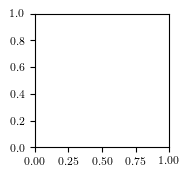

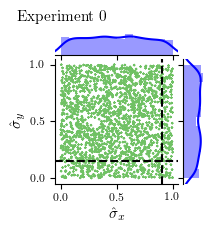

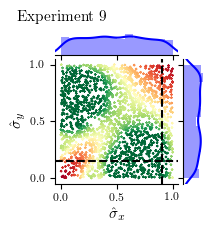

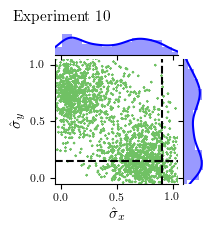

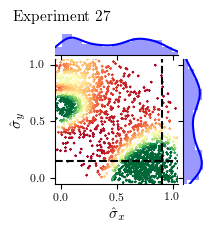

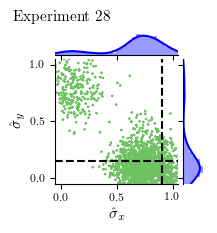

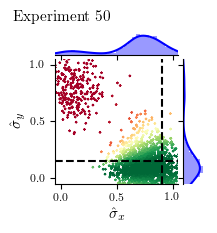

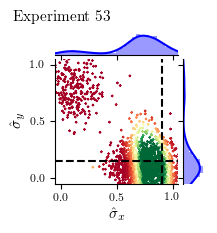

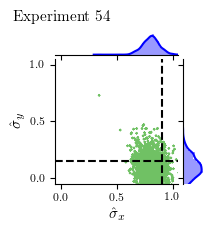

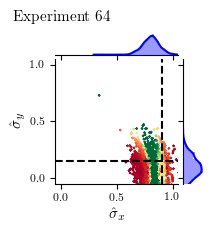

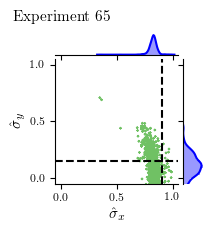

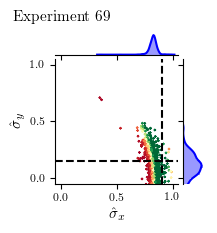

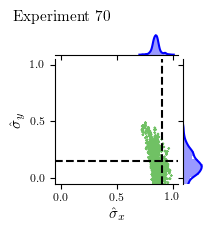

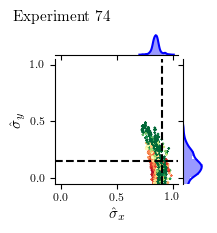

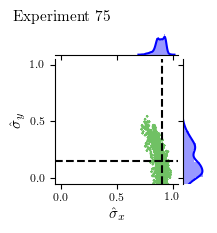

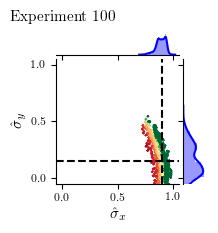

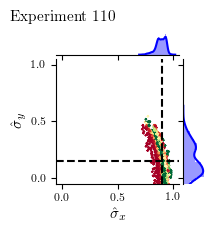

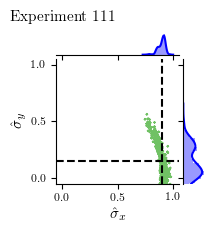

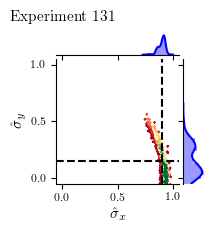

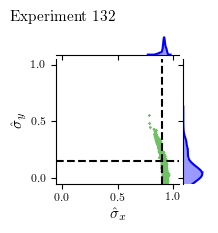

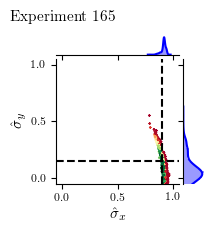

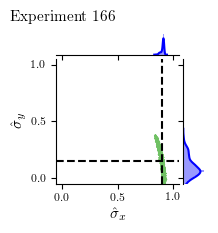

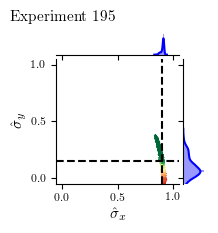

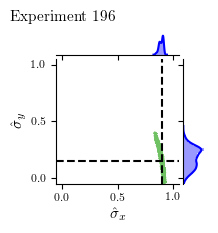

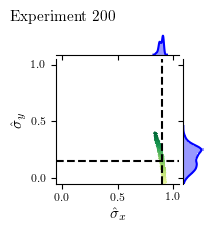

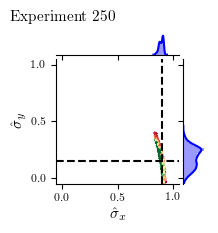

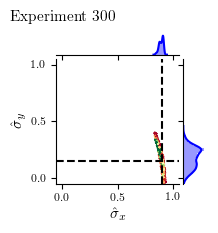

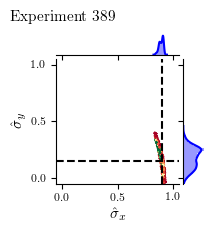

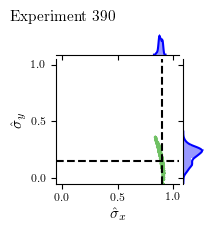

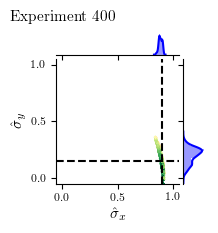

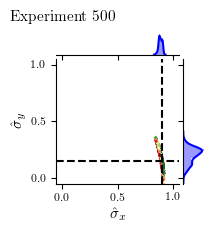

In [12]:
import copy
to_show = copy.copy(resample_record)
to_show.extend(
    [r-1 for r in resample_record]
)
to_show.extend([0, 50,  100, 200, 250, 300, 400, 500])
to_show = list(set(to_show))

max_wt = all_particles.weight.max()
min_wt = all_particles.weight.min()
median_wt = all_particles.weight.median()

weight_cmap = plt.cm.RdYlGn

wt_scale = np.percentile(all_particles.weight, 75)
# wt_scale = all_particles[all_particles.experiment_id == 0].weight.median()
# to_show= to_show[0:3]
all_particles['colour_scale'] = all_particles.weight/wt_scale
all_particles['colour'] = [weight_cmap(w) for w in all_particles.colour_scale]

lf = LatexFigure(fraction=0.28, square_plot=True)
plt.rcParams.update(lf.rc_params)
plt.rcParams['figure.figsize'] = lf.size
plt.rcParams["lines.markersize"] = 1

for epoch in sorted(set(to_show)):
    this_epoch = all_particles[all_particles.experiment_id == epoch]
    colours = this_epoch.colour
    
    g = sns.JointGrid(
        data = this_epoch, 
        x = latex_terms[0],
        y = latex_terms[1],
    )

    g = g.plot_joint(plt.scatter, c=colours, marker ='x')
    g = g.plot_marginals(sns.distplot, kde=True, color="blue")
    g.fig.suptitle('Experiment {}'.format(epoch), x = 0.15, y=1.1)

    g.ax_joint.set_xlim(-0.05,1.05)
    g.ax_joint.set_ylim(-0.05,1.05)
    g.ax_joint.set_xticks([0, 0.5, 1])
    g.ax_joint.set_yticks([0, 0.5, 1])
    
    g.ax_joint.axhline(true_model_params[terms[1]], ls='--', c='k',)
    g.ax_joint.axvline(true_model_params[terms[0]], ls='--', c='k')
    g.ax_marg_x.set_label(r"$Pr({})$".format(terms[1]))
    
    g.set_axis_labels(
#         xlabel=latex_terms[0],
#         ylabel=latex_terms[1], 
        xlabel='$\\hat{\\sigma}_{x}$',
        ylabel='$\\hat{\\sigma}_{y}$',
        fontsize=lf.font_default, 
        fontweight='bold'
    )
#     plt.tight_layout()
    g.fig.set_size_inches(lf.size)
    g.savefig(
        os.path.join(os.getcwd(), 'smc_demo', 'epoch_{}.pdf'.format(epoch)),
#         figsize=lf.size
    )
    

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


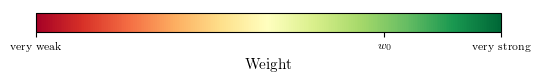

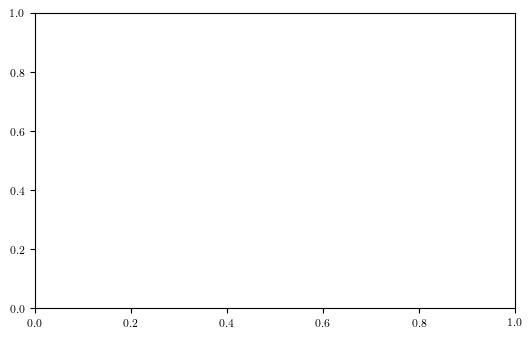

In [13]:
    

import matplotlib as mpl
cmap= weight_cmap


fig, ax = plt.subplots(figsize=(6, 0.5))
# fig, ax = plt.subplots(figsize=(1, 10))
fig.subplots_adjust(bottom=0.5)

# cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',
                                ticks=[0, 0.75, 1]
                               )
cb1.set_ticklabels(['very weak', '$w_0$', 'very strong'])
cb1.set_label('Weight')
ax.margins(x=10, y=1000)
fig.show()
lf = LatexFigure(
    fraction=1, 
)
fig.savefig(
    os.path.join(os.getcwd(), 'smc_demo', 'cbar.pdf'.format(epoch)),
    figsize=(lf.size[0]/3, lf.size[1])
)